In [2]:
import os
import re
import pickle
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from nltk.translate.bleu_score import corpus_bleu

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install opendatasets

In [5]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/adityajn105/flickr8k")

Skipping, found downloaded files in "./flickr8k" (use force=True to force download)


In [6]:
BASE_DIR = '/content/flickr8k'
WORKING_DIR = '/content/sample_data'


In [7]:
model = VGG16()

model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [9]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [10]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [11]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [12]:
mapping = {}

for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [13]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()
            caption = re.sub(r'[^a-z ]', '', caption)
            caption = re.sub(r'\s+', ' ', caption).strip()
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

clean(mapping)

In [14]:
all_captions = []
for key in mapping:
    all_captions.extend(mapping[key])

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [16]:
max_length = max(len(caption.split()) for caption in all_captions)


In [17]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [18]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    n = 0
    while True:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)
                X1, X2, y = [], [], []
                n = 0

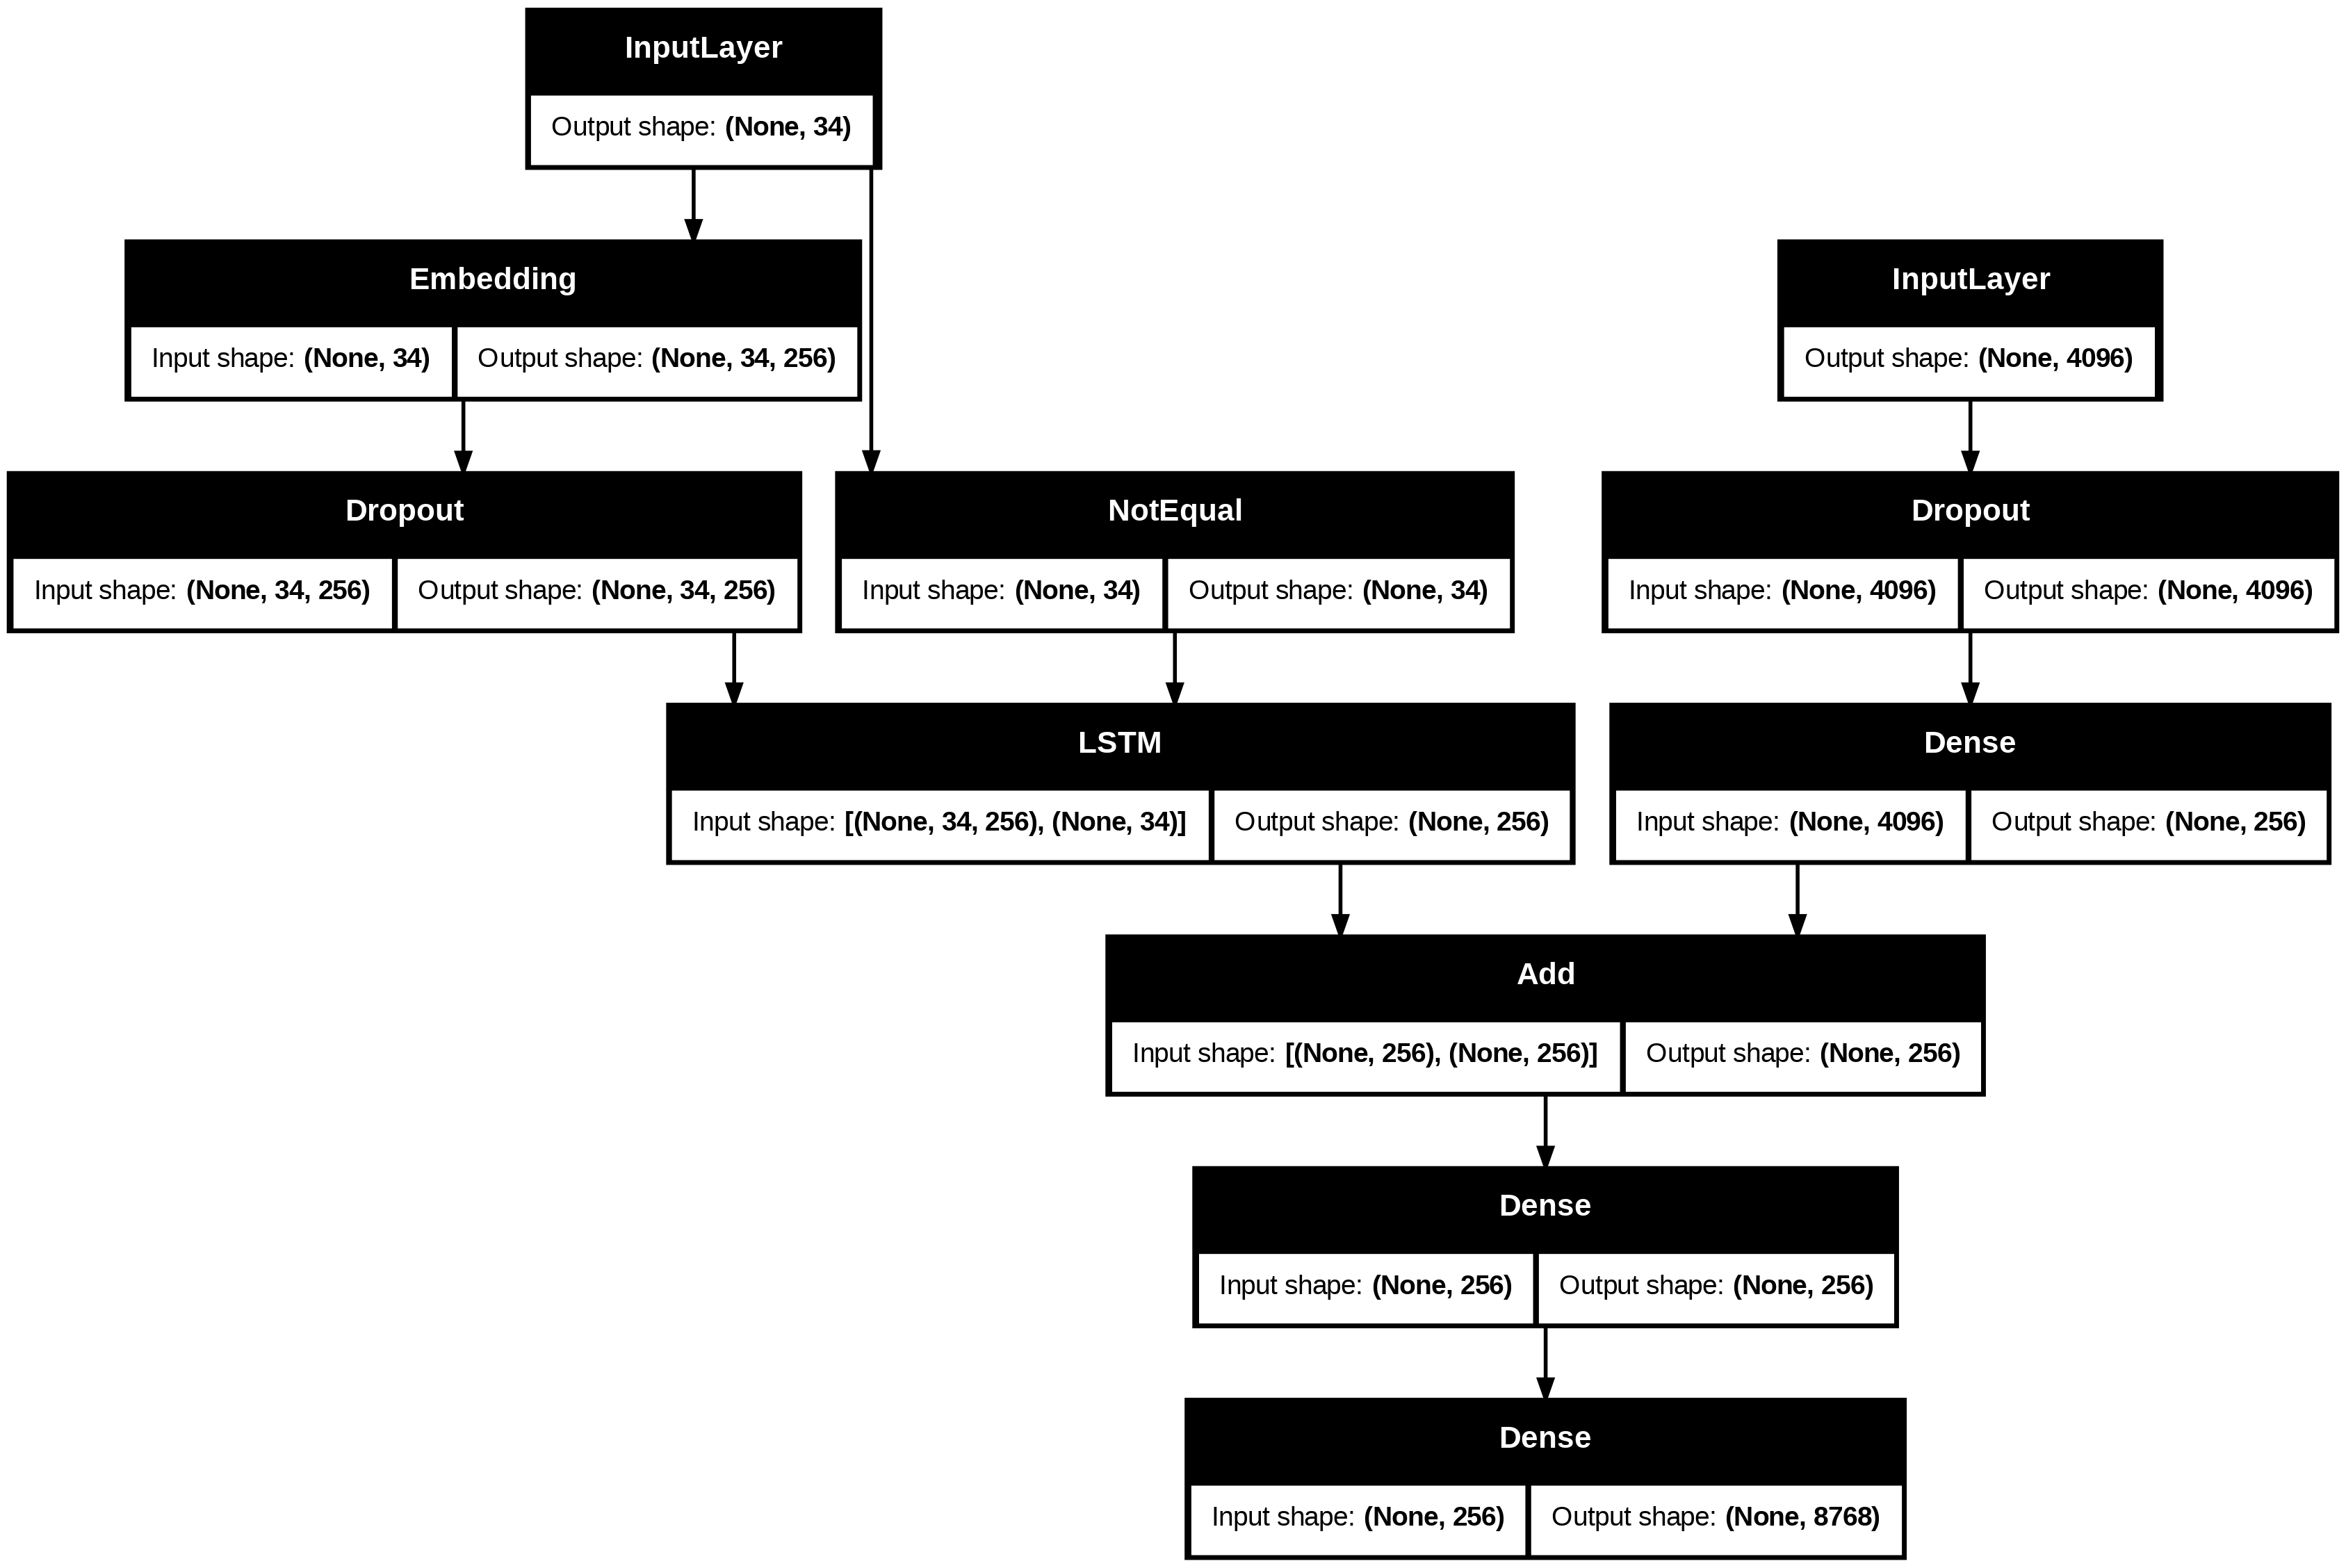

In [19]:
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

plot_model(model, show_shapes=True)

In [20]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

train_data, val_data = train_test_split(train, test_size=0.1, random_state=42)
losses = []
val_losses = []
accuracies = []
val_accuracies = []

epochs = 90
batch_size = 32
steps = len(train) // batch_size
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)


model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])


reduce_lr = ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)


early_stopping = EarlyStopping(
    monitor='loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)


callbacks = [reduce_lr, early_stopping]

for i in range(epochs):
    print(f"Epoch {i+1}/{epochs}")
    train_generator = data_generator(train_data, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    val_generator = data_generator(val_data, mapping, features, tokenizer, max_length, vocab_size, batch_size)

    history = model.fit(
        train_generator,
        epochs=1,
        steps_per_epoch=len(train_data) // batch_size,
        validation_data=val_generator,
        validation_steps=len(val_data) // batch_size,
        verbose=1,
        callbacks=callbacks
    )


    losses.append(history.history['loss'][0])
    val_losses.append(history.history['val_loss'][0])
    accuracies.append(history.history['accuracy'][0])
    val_accuracies.append(history.history['val_accuracy'][0])



Epoch 1/90
204/204 ━━━━━━━━━━━━━━━━━━━━ 40s 178ms/step - accuracy: 0.1126 - loss: 5.8643 - val_accuracy: 0.2279 - val_loss: 4.3530 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
Epoch 2/90
204/204 ━━━━━━━━━━━━━━━━━━━━ 36s 177ms/step - accuracy: 0.2457 - loss: 4.1152 - val_accuracy: 0.2694 - val_loss: 3.9650 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
Epoch 3/90
204/204 ━━━━━━━━━━━━━━━━━━━━ 36s 175ms/step - accuracy: 0.2856 - loss: 3.6148 - val_accuracy: 0.2842 - val_loss: 3.8734 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
Epoch 4/90
204/204 ━━━━━━━━━━━━━━━━━━━━ 36s 175ms/step - accuracy: 0.3075 - loss: 3.3181 - val_accuracy: 0.2894 - val_loss: 3.8782 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
Epoch 5/90
204/204 ━━━━━━━━━━━━━━━━━━━━ 36s 174ms/step - accuracy: 0.3240 - loss: 3.1018 - val_accuracy: 0.2941 - val_loss: 3.9401 - learning_ra

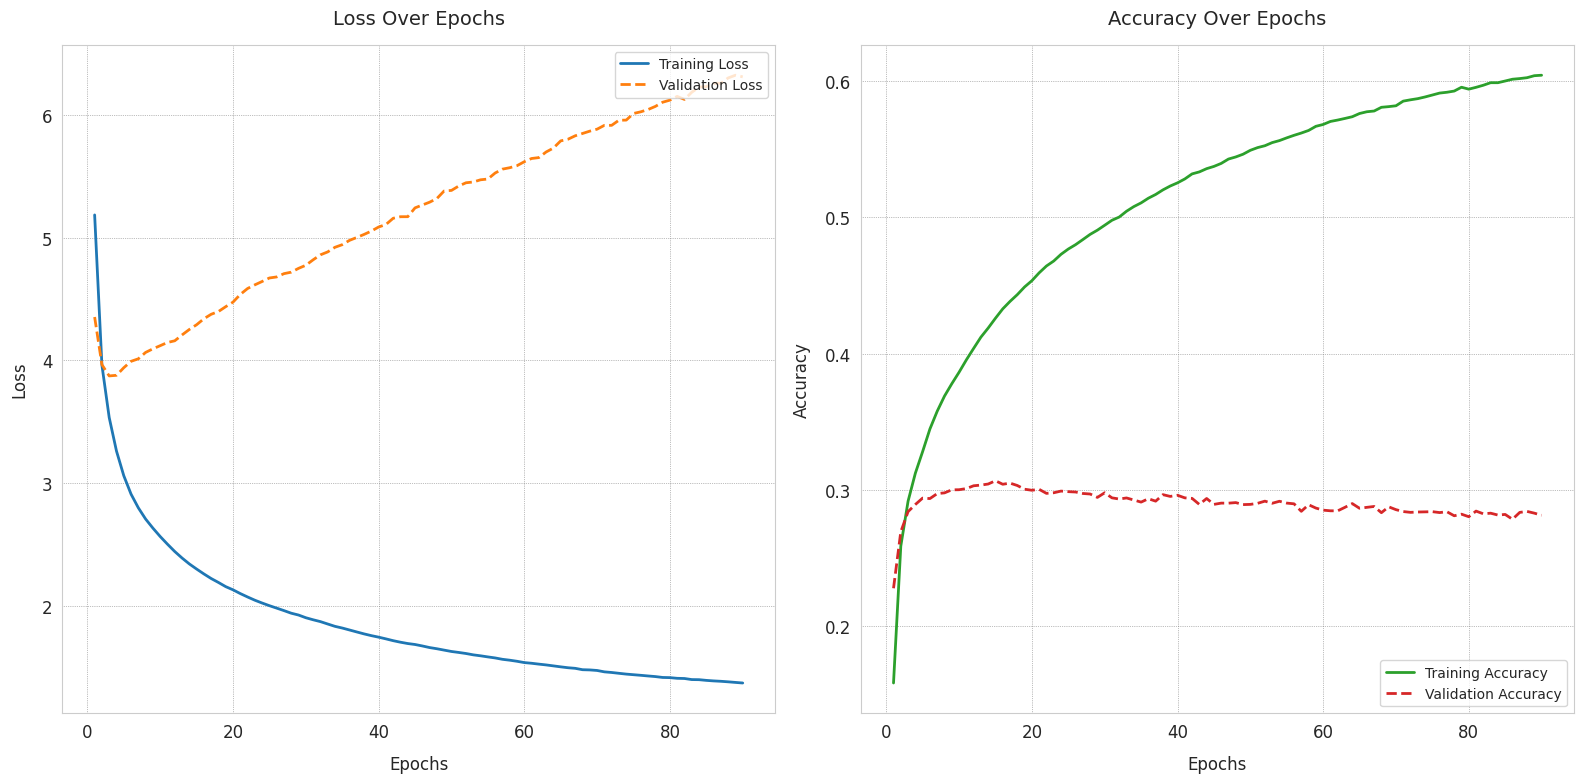

In [21]:
model.save(os.path.join(WORKING_DIR, 'model.h5'))
import seaborn as sns

sns.set_style("whitegrid")

plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 10
})
plt.figure(figsize=(16, 8))


plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), losses, label='Training Loss', color='#1f77b4', linewidth=2)
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='#ff7f0e', linestyle='--', linewidth=2)
plt.xlabel('Epochs', labelpad=10)
plt.ylabel('Loss', labelpad=10)
plt.title('Loss Over Epochs', pad=15)
plt.legend(loc='upper right')
plt.grid(color='gray', linestyle=':', linewidth=0.5)


plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), accuracies, label='Training Accuracy', color='#2ca02c', linewidth=2)
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', color='#d62728', linestyle='--', linewidth=2)
plt.xlabel('Epochs', labelpad=10)
plt.ylabel('Accuracy', labelpad=10)
plt.title('Accuracy Over Epochs', pad=15)
plt.legend(loc='lower right')
plt.grid(color='gray', linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()



In [22]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [23]:

def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text


In [24]:
actual, predicted = [], []


missing_keys = [key for key in test if key not in features]
if missing_keys:
    print(f"Missing keys in features: {missing_keys}")

for key in tqdm(test):
    if key not in features:
        continue
    captions = mapping[key]


    image_feature = features[key].reshape((1, 4096))


    y_pred = predict_caption(model, image_feature, tokenizer, max_length)


    actual_captions = [caption.split() for caption in captions]
    actual.append(actual_captions)
    predicted.append(y_pred.split())


print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.503326
BLEU-2: 0.285605


In [25]:
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq brown and white dog is running through the snow endseq
startseq dog is running in the snow endseq
startseq dog running through snow endseq
startseq white and brown dog is running through snow covered field endseq
startseq the white and brown dog is running over the surface of the snow endseq
--------------------Predicted--------------------
startseq dog is running through the snow endseq


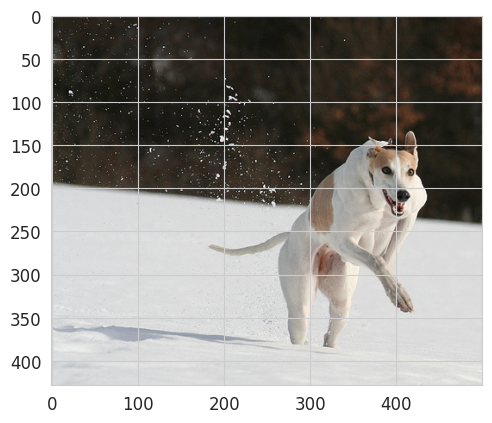

In [27]:
generate_caption("101654506_8eb26cfb60.jpg")